In [4]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch.utils.data
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from convlstm import *

import glob
from torch.utils.data import Dataset, DataLoader

# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import pickle
import numpy as np
import pandas as pd
#import os

from ast import literal_eval
#from IPython.display import clear_output

from NN_helpers import *

import seaborn as sns
sns.set(style='whitegrid',font_scale=1.2)

In [6]:
net = Net()

LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss(reduction='none')  

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [3]:
data_train = hospitalDataset('train_new.csv')
data_test = hospitalDataset('test_new.csv')



In [48]:
data_train

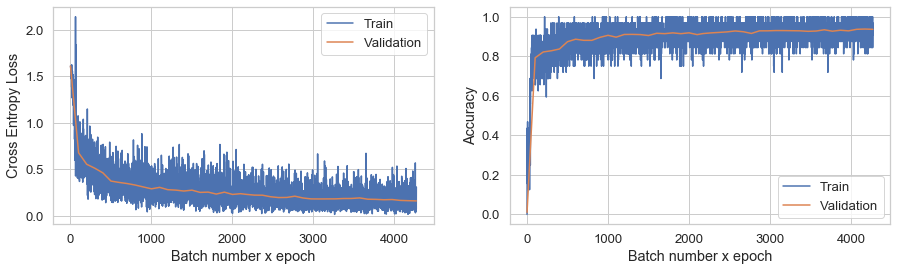

In [7]:
# Setup settings for training 
batch_size=32
max_iter = 199999
log_every = 100
eval_every = 100
num_epochs = 2



# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=0)
batch_gen_valid = DataLoader(data_test, batch_size, shuffle=True, num_workers=0)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == 0:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += torch.sum(criterion(output['out'], labels_argmax))
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]

        batch_loss = torch.mean(criterion(output['out'], labels_argmax))

        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='Train')
            plt.plot(valid_iter, valid_loss, label='Validation')
            plt.xlabel('Batch number x epoch')
            plt.ylabel('Cross Entropy Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='Train')
            plt.plot(valid_iter, valid_accs, label='Validation')
            plt.xlabel('Batch number x epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            
        if max_iter == i:
            break

In [16]:
net(transform(data,9))

torch.Size([1, 5, 8, 11, 11])
torch.Size([1, 16, 11, 11])
torch.Size([1, 8, 5, 5])
torch.Size([1, 121])
torch.Size([1, 11, 11])
torch.Size([1, 4, 11, 11])
torch.Size([1, 32, 11, 11])
torch.Size([1, 16, 5, 5])
torch.Size([1, 400])
torch.Size([1, 100])
torch.Size([1, 5])


{'out': tensor([[ 0.0149, -0.0096,  0.0015,  0.0032, -0.0168]], grad_fn=<MmBackward>)}

In [7]:
8*5*5

200

In [43]:
data.direction[0]

'[0, 1, 0, 0, 0]'

In [52]:
data_forsize = pd.read_csv('train_new.csv')

In [53]:
data_forsize.shape

(69423, 14)

In [12]:
data.direction = data.direction.fillna('[]').apply(literal_eval)

In [13]:
data.sample1 = data.sample1.fillna('[]').apply(literal_eval)
data.sample2 = data.sample2.fillna('[]').apply(literal_eval)
data.sample3 = data.sample3.fillna('[]').apply(literal_eval)
data.sample4 = data.sample4.fillna('[]').apply(literal_eval)
data.sample5 = data.sample5.fillna('[]').apply(literal_eval)

data.query_state = data.fillna('[]').query_state.apply(literal_eval)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7093 entries, 0 to 7092
Data columns (total 13 columns):
Unnamed: 0     7093 non-null int64
index          7093 non-null int64
agent          7093 non-null int64
direction      7093 non-null object
time           7093 non-null int64
agent_loc      7093 non-null object
query_state    7093 non-null object
run            7093 non-null int64
sample1        7093 non-null object
sample2        7093 non-null object
sample3        7093 non-null object
sample4        7093 non-null object
sample5        7093 non-null object
dtypes: int64(5), object(8)
memory usage: 720.5+ KB


In [10]:
print("Train, it: {} loss: {:.3f} accs: {:.3f}".format(i, train_loss[-1], train_accs[-1]))

Train, it: 2169 loss: 0.10 accs: 0.93


In [43]:
print("Valid, it: {} loss: {:.3f} accs: {:.3f}".format(i, valid_loss[-1], valid_accs[-17]))

Valid, it: 2169 loss: 0.159 accs: 0.924


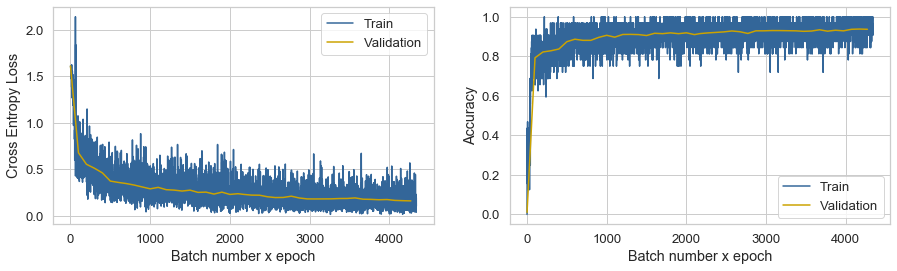

In [44]:
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter, train_loss, label='Train', color='#336699')
plt.plot(valid_iter, valid_loss, label='Validation', color='#CCA300')
plt.xlabel('Batch number x epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='Train', color='#336699')
plt.plot(valid_iter, valid_accs, label='Validation', color='#CCA300')
plt.xlabel('Batch number x epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
fig.savefig('training.png', bbox_inches='tight')

In [11]:
accuracy(output['out'], labels_argmax)

tensor(1.)

In [13]:
valid_accs[-1]

array(0.9279571, dtype=float32)

In [16]:
batch_valid['target']

tensor([[1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]])

In [17]:
net(get_input(batch_valid))

{'out': tensor([[ 4.9014e+00, -4.2447e+00, -6.0666e+00,  2.9478e+00, -3.8744e+00],
         [ 3.8045e+00, -3.3457e+00, -5.7713e-01, -3.2224e+00, -3.7887e+00],
         [ 6.6489e+00, -7.0005e+00, -3.5843e+00, -1.5256e+00, -2.7971e+00],
         [-8.1404e+00,  6.4492e+00,  6.5729e-01, -1.6385e+00, -3.5173e-02],
         [-1.1292e-03, -4.5516e+00,  4.5018e+00, -3.8731e+00, -6.2259e+00],
         [ 4.4300e+00, -6.5463e+00, -2.9116e+00,  1.9188e+00, -2.9072e+00],
         [ 4.2669e+00, -3.7988e+00, -7.6467e-01, -3.2145e+00, -3.0595e+00],
         [-4.6246e+00,  2.8961e+00,  5.0050e+00, -7.0657e+00,  1.1546e+00],
         [-6.6457e+00,  1.0212e+00,  7.1265e+00, -5.0124e+00, -1.4674e+00],
         [ 2.2772e+00, -3.2123e+00,  3.4640e-02, -3.0185e+00, -3.2127e+00],
         [-3.4143e+00,  2.9312e+00, -5.0880e-01, -1.0558e+00, -1.6978e+00],
         [-2.0833e+00,  6.2156e+00, -5.4246e+00,  1.1460e+00, -4.4165e+00],
         [ 2.2523e+00, -9.4585e+00,  1.9535e+00, -1.0227e+00, -1.3819e+00],
     

In [12]:
torch.save(net.state_dict(), 'network2')

In [54]:
model = Net()
model.load_state_dict(torch.load('network2'))
model.eval()

Net(
  (conv_1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (l_sample): Linear(in_features=200, out_features=121, bias=True)
  (conv_2): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=400, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=5, bias=False)
)

In [55]:
batch_gen_valid = DataLoader(data_test, batch_size, shuffle=True, num_workers=0)
data_test = hospitalDataset('test_new.csv')
model.eval()
for i, batch_train in enumerate(batch_gen_train):
    val_losses, val_accs, val_lengths = 0, 0, 0
    with torch.no_grad(): 
        for batch_valid in batch_gen_valid:
            num = len(batch_valid['target'])
            output = model(get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += torch.sum(criterion(output['out'], labels_argmax))
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths

KeyboardInterrupt: 

In [56]:
i

25

In [20]:
model(get_input(batch_valid))

{'out': tensor([[ 4.9014e+00, -4.2447e+00, -6.0666e+00,  2.9478e+00, -3.8744e+00],
         [ 3.8045e+00, -3.3457e+00, -5.7713e-01, -3.2224e+00, -3.7887e+00],
         [ 6.6489e+00, -7.0005e+00, -3.5843e+00, -1.5256e+00, -2.7971e+00],
         [-8.1404e+00,  6.4492e+00,  6.5729e-01, -1.6385e+00, -3.5173e-02],
         [-1.1292e-03, -4.5516e+00,  4.5018e+00, -3.8731e+00, -6.2259e+00],
         [ 4.4300e+00, -6.5463e+00, -2.9116e+00,  1.9188e+00, -2.9072e+00],
         [ 4.2669e+00, -3.7988e+00, -7.6467e-01, -3.2145e+00, -3.0595e+00],
         [-4.6246e+00,  2.8961e+00,  5.0050e+00, -7.0657e+00,  1.1546e+00],
         [-6.6457e+00,  1.0212e+00,  7.1265e+00, -5.0124e+00, -1.4674e+00],
         [ 2.2772e+00, -3.2123e+00,  3.4640e-02, -3.0185e+00, -3.2127e+00],
         [-3.4143e+00,  2.9312e+00, -5.0880e-01, -1.0558e+00, -1.6978e+00],
         [-2.0833e+00,  6.2156e+00, -5.4246e+00,  1.1460e+00, -4.4165e+00],
         [ 2.2523e+00, -9.4585e+00,  1.9535e+00, -1.0227e+00, -1.3819e+00],
     

In [24]:
for i in data_test:
    print(i)

{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




{'state': tensor([[[1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 0, 1])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 1, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([1, 0, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.]],

        [[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 1, 0, 0, 0])}
{'state': tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=torch.float64), 'target': tensor([0, 0, 0, 1, 0])}


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

